# Best Models of CV comparisons

In [2]:
########################################################################
####################### Must run modules start here#####################
########################################################################

import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import column_or_1d
from typing import Tuple, Any, Union
import random
import pickle
import uuid

In [3]:
##TODO: change directory to cwd if run on colab
%cd /content/drive/MyDrive/Colab Notebooks/vogel
%ls

/content/drive/MyDrive/Colab Notebooks/vogel
 Baseline.ipynb
'Copy of Glycomics_UGA4_Day0Day28.xlsx'
'Copy of Metabolomics_UGA4_D0toDay28.xlsx'
'Copy of metabolomics_UGA4_global_median_normalized_sample_only.quantified.txt'
'Copy of metabolomics_UGA4_untargeted_median_normalized_sample_only.quantified.txt'
'Copy of Proteomics_UGA4_Day0.xlsx'
'Copy of Transcriptomics_UGA4_day0_logCPMcounts.xlsx'
 data.arff
 data_inspect.ipynb
'fluvacc metadata - UGA1-5 - 1368 entries with clear vacc status - for figures.txt'
 KNNC2.csv
 KNNC.csv
 LOGR2.csv
 LOGR.csv
 meta.txt
 RFC2.csv
 RFC.csv
 SGDC2.csv
 SGDC_best.pkl
 SGDC.csv
 SVC2.csv
 SVC.csv
 test_examples.csv
 train_examples.csv


# PreProcessing
Some codes are reorganized for new implementations.

In [4]:
def split_age_groups(df): #split the dataset based on differen age groups
  return [df.loc[df["Age_dup"]<18], df.loc[df["Age_dup"]>= 18].loc[df["Age_dup"]<65], df.loc[df["Age_dup"] >= 65]]

In [5]:
class CustomLabelEncoder(LabelEncoder):
  def __init__(self, month_one_hot=True):
      self.month_one_hot = month_one_hot
  def fit(self, y, ordering: list):  # take an ordering list as an argument
      y = column_or_1d(y, warn=True)
      assert set(ordering) == set(pd.Series(y).unique())
      self.classes_ = ordering
      return self


In [6]:
def basic_preprocessing2(df_original, month_one_hot=True, normalize=True, binary_classification=True, drop_none=False):  # added non in-place implementation
  df = df_original.copy(deep=True)
  df.loc[df["BMI_category"] == "Normal ", "BMI_category"] = "Normal"
  df.loc[df["BMI_category"] == "Obese ", "BMI_category"] = "Obese"
  
  df["BMI_log"] = np.log(df["BMI"])
  df["Age_log"] = np.log(df["Age"])
  df["Age_dup"] = df["Age"]

  def _normalize(data):
      scaler = StandardScaler()
      scaler.fit(data)
      data = scaler.transform(data)
      return data

  if normalize:
    numerical_cols = ["BMI_log", "Age_log", "Age", "BMI","D0_Titer_H1N1","D0_Titer_H3N2", "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic"]
    df[numerical_cols] = _normalize(df[numerical_cols])

  bmi_cat = df["BMI_category"]
  df2 = df.drop("BMI_category", axis=1)
  comorbidities = df["Comorbidities"]
  df2 = df2.drop("Comorbidities", axis=1)
  dose = df["Vaccine_dose"]
  df2 = df2.drop("Vaccine_dose", axis=1)
  month = None
  if not month_one_hot:
    month = df["Month_vaccinated"]
    df2 = df2.drop("Month_vaccinated", axis=1)

  pre_vac = df["PreVacc_status"]
  df2 = df2.drop("PreVacc_status", axis=1)
  pre_vac_year = df["PreVacc_status_year"]
  df2 = df2.drop("PreVacc_status_year", axis=1)
  h1n1 = df["SC_category_H1N1"]
  df2 = df2.drop("SC_category_H1N1", axis=1)
  h3n2 = df["SC_category_H3N2"]
  df2 = df2.drop("SC_category_H3N2", axis=1)
  yam = df["SC_category_IBV_Yam"]
  df2 = df2.drop("SC_category_IBV_Yam", axis=1)
  vic = df["SC_category_IBV_Vic"]
  df2 = df2.drop("SC_category_IBV_Vic", axis=1)
  comp = df["Composite_SC_category"]
  df2 = df2.drop("Composite_SC_category", axis=1)
  base = df["Baseline_category_Num_SeroPos_strains"]
  df2 = df2.drop("Baseline_category_Num_SeroPos_strains", axis=1)

  for i, column in enumerate(df2.select_dtypes(exclude=["number"]).iloc[:,2:].columns):
    temp = pd.get_dummies(df2[column], drop_first=True, prefix=column)
    df = df.drop(column, axis=1)
    if i != 0 :
      x = x.join(temp)
    else:
      x = temp
  
  # mapping from columns to correct ordering
  ordering_dict = {"BMI_category": (bmi_cat, ["Lean", "Normal", "Overweight", "Obese"]),
                 "Comorbidities": (comorbidities, ["No", "Yes"]),
                 "Vaccine_dose": (dose, ["Standard", "High"]),
                 "PreVacc_status": (pre_vac, ["Naive", "Prevaccinated"]),
                 "PreVacc_status_year": (pre_vac_year, ["Year_3", "Year_0"]),
                 "SC_category_H1N1": (h1n1, ["None", "Low", "High"]),
                 "SC_category_H3N2": (h3n2, ["None", "Low", "High"]),
                 "SC_category_IBV_Yam": (yam, ["None", "Low", "High"]),
                 "SC_category_IBV_Vic": (vic, ["None", "Low", "High"]),
                 "Composite_SC_category": (comp, ["None", "Low", "High"]),
                 "Baseline_category_Num_SeroPos_strains": (base, ["Low", "High"])}  
  if not month_one_hot:
    ordering_dict["Month_vaccinated"] = (month, ["Sep.", "Oct.", "Nov.", "Dec.", "Jan.", "Feb."])
  if binary_classification and not drop_none:
    ordering_dict["SC_category_H1N1"][1].pop(0)
    ordering_dict["SC_category_H3N2"][1].pop(0)
    ordering_dict["SC_category_IBV_Yam"][1].pop(0)
    ordering_dict["SC_category_IBV_Vic"][1].pop(0)
    ordering_dict["Composite_SC_category"][1].pop(0)
    h1n1.loc[h1n1 == "None"] = "Low"
    h3n2.loc[h3n2 == "None"] = "Low"
    yam.loc[yam == "None"] = "Low"
    vic.loc[vic == "None"] = "Low"
    comp.loc[comp == "None"] = "Low"

  lencoder = CustomLabelEncoder(month_one_hot)
  for key, value in ordering_dict.items():
    lencoder.fit(value[0], value[1])
    df.loc[:, key] = lencoder.transform(value[0])

  new = df.join(x)
  if drop_none:
    new = new.loc[new["SC_category_H1N1"] != "None"]
  
  test = new.sample(frac=0.3, axis=0)
  test_strip = test.iloc[:,2:]
  train = new.drop(test.index)
  train_strip = train.iloc[:,2:]
  return train_strip, test_strip


def basic_preprocessing(df, month_one_hot=True, normalize=True, exclude=True, binary_classification=True, drop_none=False):
  df.loc[df["BMI_category"] == "Normal ", "BMI_category"] = "Normal"
  df.loc[df["BMI_category"] == "Obese ", "BMI_category"] = "Obese"
  
  df["BMI_log"] = np.log(df["BMI"])
  df["Age_log"] = np.log(df["Age"])
  df["Age_dup"] = df["Age"]

  def _normalize(data):
      scaler = StandardScaler()
      scaler.fit(data)
      data = scaler.transform(data)
      return data

  if normalize:
    numerical_cols = ["BMI_log", "Age_log", "Age", "BMI","D0_Titer_H1N1","D0_Titer_H3N2", "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic"]
    df[numerical_cols] = _normalize(df[numerical_cols])

  bmi_cat = df["BMI_category"]
  df2 = df.drop("BMI_category", axis=1)
  comorbidities = df["Comorbidities"]
  df2 = df2.drop("Comorbidities", axis=1)
  dose = df["Vaccine_dose"]
  df2 = df2.drop("Vaccine_dose", axis=1)
  month = None
  if not month_one_hot:
    month = df["Month_vaccinated"]
    df2 = df2.drop("Month_vaccinated", axis=1)

  pre_vac = df["PreVacc_status"]
  df2 = df2.drop("PreVacc_status", axis=1)
  pre_vac_year = df["PreVacc_status_year"]
  df2 = df2.drop("PreVacc_status_year", axis=1)
  h1n1 = df["SC_category_H1N1"]
  df2 = df2.drop("SC_category_H1N1", axis=1)
  h3n2 = df["SC_category_H3N2"]
  df2 = df2.drop("SC_category_H3N2", axis=1)
  yam = df["SC_category_IBV_Yam"]
  df2 = df2.drop("SC_category_IBV_Yam", axis=1)
  vic = df["SC_category_IBV_Vic"]
  df2 = df2.drop("SC_category_IBV_Vic", axis=1)
  comp = df["Composite_SC_category"]
  df2 = df2.drop("Composite_SC_category", axis=1)
  base = df["Baseline_category_Num_SeroPos_strains"]
  df2 = df2.drop("Baseline_category_Num_SeroPos_strains", axis=1)

  for i, column in enumerate(df2.select_dtypes(exclude=["number"]).iloc[:,2:].columns):
    temp = pd.get_dummies(df2[column], drop_first=True, prefix=column)
    df = df.drop(column, axis=1)
    if i != 0 :
      x = x.join(temp)
    else:
      x = temp
  
  # mapping from columns to correct ordering
  ordering_dict = {"BMI_category": (bmi_cat, ["Lean", "Normal", "Overweight", "Obese"]),
                 "Comorbidities": (comorbidities, ["No", "Yes"]),
                 "Vaccine_dose": (dose, ["Standard", "High"]),
                 "PreVacc_status": (pre_vac, ["Naive", "Prevaccinated"]),
                 "PreVacc_status_year": (pre_vac_year, ["Year_3", "Year_0"]),
                 "SC_category_H1N1": (h1n1, ["None", "Low", "High"]),
                 "SC_category_H3N2": (h3n2, ["None", "Low", "High"]),
                 "SC_category_IBV_Yam": (yam, ["None", "Low", "High"]),
                 "SC_category_IBV_Vic": (vic, ["None", "Low", "High"]),
                 "Composite_SC_category": (comp, ["None", "Low", "High"]),
                 "Baseline_category_Num_SeroPos_strains": (base, ["Low", "High"])}  
  if not month_one_hot:
    ordering_dict["Month_vaccinated"] = (month, ["Sep.", "Oct.", "Nov.", "Dec.", "Jan.", "Feb."])
  if binary_classification and not drop_none:
    ordering_dict["SC_category_H1N1"][1].pop(0)
    ordering_dict["SC_category_H3N2"][1].pop(0)
    ordering_dict["SC_category_IBV_Yam"][1].pop(0)
    ordering_dict["SC_category_IBV_Vic"][1].pop(0)
    ordering_dict["Composite_SC_category"][1].pop(0)
    h1n1.loc[h1n1 == "None"] = "Low"
    h3n2.loc[h3n2 == "None"] = "Low"
    yam.loc[yam == "None"] = "Low"
    vic.loc[vic == "None"] = "Low"
    comp.loc[comp == "None"] = "Low"

  lencoder = CustomLabelEncoder(month_one_hot)
  for key, value in ordering_dict.items():
    lencoder.fit(value[0], value[1])
    df.loc[:, key] = lencoder.transform(value[0])
  new = df.join(x)
  
  if drop_none:
    new = new.loc[new["SC_category_H1N1"] != "None"]
  test = new.sample(frac=0.2)
  new_UGA4 = new[new.iloc[:,0] == "UGA4"]  # get two versions of the data: UGA4 and full version; drop the ID columns
  new_UGA4_strip = new_UGA4.iloc[:,2:]
  if exclude:
    new = new[new.iloc[:,0] != "UGA4"]
  new_strip = new.iloc[:,2:]
  return new_strip, new_UGA4_strip

In [7]:
def io_selector(data: DataFrame, 
                input_columns: Union[list, str] = None, # 'all' for all input columns. Used for feature selection
                output_column: str = None, 
                month_one_hot: bool = True,
                split_feature_label=True,
                split_age=False,
                keep_original=False
                ):
  if split_age:
    data_groups = split_age_groups(data)
    if keep_original:
      data_groups.append(data)
  else:
    data_groups = [data]
  
  complete_input_columns = ["Age_log", "BMI_log", "BMI_category", "Gender_Male", "Race_White", 
                              "Comorbidities", "PreVacc_status", "PreVacc_status_year", 
                            "Vaccine_dose", "D0_Titer_H1N1", 
                          "D0_Titer_H3N2", "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic"]

  default_input_columns = ["Age_log", "BMI_log", "Gender_Male", "Race_White", "Comorbidities", 
                          "PreVacc_status", "Vaccine_dose",
                          "D0_Titer_H1N1", "D0_Titer_H3N2", "D0_Titer_IBV_Yam", 
                          "D0_Titer_IBV_Vic"]
  name_mapping = {"Gender": ["Gender_Male"], "Race": ["Race_White"]}
  if month_one_hot:
    default_input_columns.extend(["Month_vaccinated_Jan.", "Month_vaccinated_Feb.",
                          "Month_vaccinated_Sep.", "Month_vaccinated_Oct.",
                          "Month_vaccinated_Nov."])
    complete_input_columns.extend(["Month_vaccinated_Jan.", "Month_vaccinated_Feb.",
                          "Month_vaccinated_Sep.", "Month_vaccinated_Oct.",
                          "Month_vaccinated_Nov."])
    name_mapping["Month_vaccinated"] = ["Month_vaccinated_Jan.",
                                      "Month_vaccinated_Feb.",
                                      "Month_vaccinated_Sep.", 
                                      "Month_vaccinated_Oct.", 
                                      "Month_vaccinated_Nov."]
  else:
    default_input_columns.append("Month_vaccinated")
    complete_input_columns.append("Month_vaccinated")
    
                          
  default_output = ["Composite_seroconversion"]

  
  if input_columns is None: 
    input_columns = default_input_columns
  elif input_columns == "all":
    input_columns = complete_input_columns
  else:
    temp = []
    for item in input_columns:
      if item in name_mapping:
        temp.extend(name_mapping[item])
      else:
        temp.append(item)
    input_columns = temp
  if output_column is None:
    output_column = default_output
  
  output_groups = []
  for data in data_groups:
    x = data[input_columns]
    y = data[output_column]
    if not split_feature_label:
      output_groups.append(x.join(y))
    else:
      output_groups.append((x, y))
  return output_groups


In [8]:
# handles data converting and saving. Use feature_selection_dataset_wrapper if feature selection is needed
def dataset_wrapper(train: DataFrame,
                    test: DataFrame, 
                    input_columns: Union[list,str] = None, 
                    output_column: str = None,
                    save: bool = False,  # whether to save data in cwd
                    name_extension: str = "",  # name extension for file save
                    to_numpy: bool = True,  # whether to convert to numpy, set to false if feature selection is needed
                    split_age=False,
                    split_age_test=False,
                    keep_original=False):  # returns X_train, y_train, X_dev, y_dev, X_test, y_test
  train_groups = io_selector(train, input_columns, output_column, split_age=split_age)
  test_groups = io_selector(test, input_columns, output_column, split_age=split_age_test, keep_original=keep_original)
  X_trains = []
  y_trains = []
  X_tests = []
  y_tests = []
  for X_train, y_train in train_groups:
    if save:
      X_train.to_csv("X_train_" + name_extension + ".csv", index=False)
      y_train.to_csv("y_train_" + name_extension + ".csv", index=False)

    if to_numpy:
      X_train = X_train.to_numpy()
      y_train = y_train.to_numpy()

    X_trains.append(X_train)
    y_trains.append(y_train)

  for X_test, y_test in test_groups:
    if save:
      
      X_test.to_csv("X_test_" + name_extension + ".csv", index=False)
      y_test.to_csv("y_test_" + name_extension + ".csv", index=False)
    if to_numpy:
      
      X_test = X_test.to_numpy()
      y_test = y_test.to_numpy()
    X_tests.append(X_test)
    y_tests.append(y_test)
  
    
  return X_trains, y_trains, X_tests, y_tests




# Training

In [9]:
from sklearn.linear_model import LinearRegression, SGDRegressor, SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

def train_wrapper(X_train: np.ndarray,  # dataset
                  y_train: np.ndarray,
                # Universal parameters (one or more models)
                method: str = None,  # model name
                random_state: int = 10,  # random seed
                model_path: str = None,  # path to save the model, no saving if None
                n_jobs: int = -1,  # number of CPUs to use for some models. -1 means all processors
                max_iter: int = 10000,  # max number of iterations for some models, set to -1 for SV to impose no limits 
                class_weight: Union[dict, str] = None,  # weight of each class or balanced
                penalty: str = "l2",  # logistic has the option of no penalty "None"
                C: float = 1.0, # regularization for logistic or SVM
                # Model specific parameters:
                # SGD Regressor/Classifier
                loss: str = "squared_error",
                alpha: float = 0.01,
                l1_ratio: float = 0.15,
                SGD_epsilon: float = 0.1,
                learning_rate: str = "invscaling",
                eta0: float = 1e-2,
                power_t: float = 0.25,
                average: Union[bool, int] = False,
                # KNN Regressor/Classifier
                n_neighbors: int = 5,
                weights: str = "uniform",
                algorithm: str = "brute",
                leaf_size: int = 30,
                p: int = 2,
                metric: Union[str, callable] = "minkowski",
                metric_params: dict = None,
                # Logistic Regression
                dual: bool = False,
                intercept_scaling: float = 1,
                solver: str = "lbfgs",
                multi_class: str = "auto",
                # Random Forest Classifier/Regressor
                n_estimates: int = 100,
                RFC_criterion: str = "gini",
                RFR_criterion: str = "squared_error",
                max_depth: int = None,
                min_sample_split: Union[int, float] = 2,
                min_samples_leaf: Union[int, float] = 1,
                min_weight_fraction_leaf: float = 0.0,
                max_features: Union[str, int, float] = "auto",
                max_leaf_nodes: int = None,
                min_impurity_decrease: float = 0.0,
                bootstrap: bool = True,
                oob_score: bool = True,
                ccp_alpha: float = 0.0,
                max_samples: Union[int,float] = None,
                # SVC/SVR
                kernel: str = "rbf",
                degree: int = 3,
                gamma: str = "scale",
                coef0: float = 0.0,
                shrinking: bool = True,
                probability: bool = False,
                decision_fuction_shape: str = "ovr",
                break_ties: bool = False,
                SVC_epsilon: float = 0.1,
                ):  # returns a trained model
  random.seed(random_state)
  model = LinearRegression()
  if method == "LR":
    model = LinearRegression()
  elif method == "SGDR":
    model = SGDRegressor(loss=loss, penalty=penalty, alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, verbose=0, epsilon=SGD_epsilon, random_state=random_state, learning_rate=learning_rate, eta0=eta0, power_t=power_t, average=average)
  elif method == "KNNR":
    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, p=p, metric=metric)
  elif method == "SGDC":
    model = SGDClassifier(loss=loss, penalty=penalty, alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, verbose=0, epsilon=SGD_epsilon, n_jobs=n_jobs, random_state=random_state, learning_rate=learning_rate, eta0=eta0, power_t=power_t, class_weight=class_weight, average=average)
  elif method == "KNNC":
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, p=p, metric=metric)
  elif method == "LOGR":
    model = LogisticRegression(penalty=penalty, dual=dual, C=C, intercept_scaling=intercept_scaling, class_weight=class_weight, random_state=random_state, solver=solver, max_iter=max_iter, multi_class=multi_class, verbose=1, n_jobs=n_jobs, l1_ratio=l1_ratio)
  elif method == "RFC":
    model = RandomForestClassifier(n_estimators=n_estimates, criterion=RFC_criterion, max_depth=max_depth, min_samples_split=min_sample_split, min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, verbose=1, class_weight=class_weight, ccp_alpha=ccp_alpha, max_samples=max_samples)
  elif method == "RFR":
    model = RandomForestRegressor(n_estimators=n_estimates, criterion=RFR_criterion, max_depth=max_depth, min_samples_split=min_sample_split, min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, verbose=1, ccp_alpha=ccp_alpha, max_samples=max_samples)
  elif method == "SVC":
    model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, coef0=coef0, shrinking=shrinking, probability=probability, class_weight=class_weight, verbose=1, max_iter=max_iter, decision_function_shape=decision_fuction_shape, break_ties=break_ties, random_state=random_state)
  elif method == "SVR":
    model = SVR(kernel=kernel, degree=degree, gamma=gamma, coef0=coef0, C=C, shrinking=shrinking, epsilon=SVC_epsilon, verbose=1, max_iter=max_iter)
  model.fit(X_train,y_train)
  if model_path:
    with open(method + str(uuid.uuid1())[:6] + ".pkl", "wb") as f:
      pickle.dump(model, f)
  return model

########################################################################
####################### Must run modules end here ######################
########################################################################

# The following sections are evaluation of baseline models and CV'd best models on random split dataset. See previous version for basic formatting information



In [ ]:
from sklearn.metrics import classification_report  # import evaluation package
metrics = ["accuracy", "average_precision", "f1", "precision", "recall", "roc_auc"]  # define evaluation metrics

In [ ]:
df = pd.read_csv("fluvacc metadata - UGA1-5 - 1368 entries with clear vacc status - for figures.txt", sep="\t")  ##TODO: put the name of the file here
train_df, test_df = basic_preprocessing2(df, normalize=True)  # this gives randomly split data
model_name_list = ["LOGR", "KNNC", "SGDC", "RFC", "SVC"]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
train_df.to_csv("train_examples.csv")   #manual save
test_df.to_csv("test_examples.csv")

In [ ]:
train_df = pd.read_csv("train_examples.csv")  #manual load
test_df = pd.read_csv("test_examples.csv")


baseline on all age groups

In [ ]:
X_trains, y_trains, X_tests, y_tests = dataset_wrapper(train_df, test_df, 
                                                  input_columns=["Age_log", "BMI_log", 
                                                                  "BMI_category", "Gender_Male", 
                                                                  "Race_White", "Comorbidities", 
                                                                  "PreVacc_status_year", "Vaccine_dose", 
                                                                  "D0_Titer_H1N1", "D0_Titer_H3N2", 
                                                                  "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic", 
                                                                  "Month_vaccinated_Jan.","Month_vaccinated_Feb.", 
                                                                  "Month_vaccinated_Sep.", "Month_vaccinated_Oct.", 
                                                                  "Month_vaccinated_Nov."], 
                                                  output_column= "Composite_SC_category",
                                                  split_age=False,
                                                  split_age_test=False)

if len(X_tests) == 1:
  map = {0: "on all age groups"}
else:
  map = {0: "on child", 1: "on adult1", 2: "on adult2"}
for model_name in model_name_list:
  for i in range(len(X_trains)):
    model = train_wrapper(X_trains[i], y_trains[i], method=model_name)
    for j in range(len(X_tests)):
      print("NIR:", classification_report(y_tests[j],np.zeros(len(y_tests[j]))))
      res = model.predict(X_tests[j])
      res[res>= 0.5] = 1
      res[res<0.5] = 0
      res = res.astype(int)
      print(model_name, ":\n", classification_report(y_tests[j], res), "\n", map[j])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

NIR:               precision    recall  f1-score   support

           0       0.78      1.00      0.88       321
           1       0.00      0.00      0.00        89

    accuracy                           0.78       410
   macro avg       0.39      0.50      0.44       410
weighted avg       0.61      0.78      0.69       410

LOGR :
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       321
           1       0.85      0.58      0.69        89

    accuracy                           0.89       410
   macro avg       0.87      0.78      0.81       410
weighted avg       0.88      0.89      0.88       410
 
 on all age groups
NIR:               precision    recall  f1-score   support

           0       0.78      1.00      0.88       321
           1       0.00      0.00      0.00        89

    accuracy                           0.78       410
   macro avg       0.39      0.50      0.44       410
weighted avg       0.61      0.78   

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 i

NIR:               precision    recall  f1-score   support

           0       0.78      1.00      0.88       321
           1       0.00      0.00      0.00        89

    accuracy                           0.78       410
   macro avg       0.39      0.50      0.44       410
weighted avg       0.61      0.78      0.69       410

RFC :
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       321
           1       0.81      0.63      0.71        89

    accuracy                           0.89       410
   macro avg       0.86      0.79      0.82       410
weighted avg       0.88      0.89      0.88       410
 
 on all age groups
[LibSVM]NIR:               precision    recall  f1-score   support

           0       0.78      1.00      0.88       321
           1       0.00      0.00      0.00        89

    accuracy                           0.78       410
   macro avg       0.39      0.50      0.44       410
weighted avg       0.61      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Optimal on all age groups

In [ ]:
X_trains, y_trains, X_tests, y_tests = dataset_wrapper(train_df, test_df, 
                                                  input_columns=["Age_log", "BMI_log", 
                                                                  "BMI_category", "Gender_Male", 
                                                                  "Race_White", "Comorbidities", 
                                                                  "PreVacc_status_year", "Vaccine_dose", 
                                                                  "D0_Titer_H1N1", "D0_Titer_H3N2", 
                                                                  "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic", 
                                                                  "Month_vaccinated_Jan.","Month_vaccinated_Feb.", 
                                                                  "Month_vaccinated_Sep.", "Month_vaccinated_Oct.", 
                                                                  "Month_vaccinated_Nov."], 
                                                  output_column= "Composite_SC_category",
                                                  split_age=False,
                                                  split_age_test=False)
if len(X_tests) == 1:
  map = {0: "on all age groups"}
else:
  map = {0: "on child", 1: "on adult1", 2: "on adult2"}
for model_name in model_name_list:
  for i in range(len(X_trains)):
    model = None
    if model_name == "LOGR":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, model_path=True, C=0.5, dual=False, intercept_scaling=5, l1_ratio=0.75, penalty="l2", solver="saga") #optimal LOGR
    elif model_name == "SVC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, model_path=True, C=10, dual=False, shrinking=True, probability=True, kernel="poly", gamma="auto", degree=2, decision_fuction_shape="ovr", coef0=1, break_ties=False) #optimal SVC
    elif model_name == "SGDC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, model_path=True, power_t=0.57,  penalty="l2", loss="perceptron", learning_rate="invscaling", l1_ratio=0, eta0=0.00001, SGD_epsilon=0.7, average=True, alpha=0.01) #optimal SGDC
    elif model_name == "RFC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, model_path=True, oob_score=False,  n_estimates=75, min_weight_fraction_leaf=0, min_sample_split=2, min_samples_leaf=1, min_impurity_decrease=0, max_samples=0.75, max_leaf_nodes=100, max_features="auto", max_depth=1000, RFC_criterion="gini", ccp_alpha=0, bootstrap=True) #optimal RFC
    elif model_name == "KNNC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, model_path=True, weights="uniform", p=2, n_neighbors=5, metric_params={"V":2}, metric="minkowski", leaf_size=50, algorithm="brute") # optimal KNNC
    for j in range(len(X_tests)):
      res = model.predict(X_tests[j])
      res[res>= 0.5] = 1
      res[res<0.5] = 0
      res = res.astype(int)
      print(model_name, ":\n", classification_report( y_tests[j], res), "\n", map[j])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


convergence after 157 epochs took 0 seconds
LOGR :
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       321
           1       0.85      0.57      0.68        89

    accuracy                           0.89       410
   macro avg       0.87      0.77      0.81       410
weighted avg       0.88      0.89      0.88       410
 
 on all age groups
KNNC :
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       321
           1       0.69      0.48      0.57        89

    accuracy                           0.84       410
   macro avg       0.78      0.71      0.74       410
weighted avg       0.83      0.84      0.83       410
 
 on all age groups
SGDC :
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       321
           1       0.80      0.60      0.68        89

    accuracy                           0.88       410
   macro avg       0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.1s finished


RFC :
               precision    recall  f1-score   support

           0       0.90      0.97      0.94       321
           1       0.86      0.62      0.72        89

    accuracy                           0.90       410
   macro avg       0.88      0.79      0.83       410
weighted avg       0.89      0.90      0.89       410
 
 on all age groups
[LibSVM]SVC :
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       321
           1       0.88      0.55      0.68        89

    accuracy                           0.89       410
   macro avg       0.88      0.76      0.80       410
weighted avg       0.88      0.89      0.88       410
 
 on all age groups


Baseline on separate groups

In [ ]:
X_trains, y_trains, X_tests, y_tests = dataset_wrapper(train_df, test_df, 
                                                  input_columns=["Age_log", "BMI_log", 
                                                                  "BMI_category", "Gender_Male", 
                                                                  "Race_White", "Comorbidities", 
                                                                  "PreVacc_status_year", "Vaccine_dose", 
                                                                  "D0_Titer_H1N1", "D0_Titer_H3N2", 
                                                                  "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic", 
                                                                  "Month_vaccinated_Jan.","Month_vaccinated_Feb.", 
                                                                  "Month_vaccinated_Sep.", "Month_vaccinated_Oct.", 
                                                                  "Month_vaccinated_Nov."], 
                                                  output_column= "Composite_SC_category",
                                                  split_age=False,
                                                  split_age_test=True)

if len(X_tests) == 1:
  map = {0: "on all age groups"}
else:
  map = {0: "on child", 1: "on adult1", 2: "on adult2"}
for model_name in model_name_list:
  for i in range(len(X_trains)):
    model = train_wrapper(X_trains[i], y_trains[i], method=model_name)
    for j in range(len(X_tests)):
      print("NIR:", classification_report(y_tests[j],np.zeros(len(y_tests[j]))))
      res = model.predict(X_tests[j])
      res[res>= 0.5] = 1
      res[res<0.5] = 0
      res = res.astype(int)
      print(model_name, ":\n", classification_report(y_tests[j], res), "\n", map[j])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

NIR:               precision    recall  f1-score   support

           0       0.77      1.00      0.87        92
           1       0.00      0.00      0.00        27

    accuracy                           0.77       119
   macro avg       0.39      0.50      0.44       119
weighted avg       0.60      0.77      0.67       119

LOGR :
               precision    recall  f1-score   support

           0       0.90      0.99      0.94        92
           1       0.94      0.63      0.76        27

    accuracy                           0.91       119
   macro avg       0.92      0.81      0.85       119
weighted avg       0.91      0.91      0.90       119
 
 on child
NIR:               precision    recall  f1-score   support

           0       0.79      1.00      0.88       176
           1       0.00      0.00      0.00        48

    accuracy                           0.79       224
   macro avg       0.39      0.50      0.44       224
weighted avg       0.62      0.79      0.69  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 i

NIR:               precision    recall  f1-score   support

           0       0.77      1.00      0.87        92
           1       0.00      0.00      0.00        27

    accuracy                           0.77       119
   macro avg       0.39      0.50      0.44       119
weighted avg       0.60      0.77      0.67       119

RFC :
               precision    recall  f1-score   support

           0       0.91      0.99      0.95        92
           1       0.95      0.67      0.78        27

    accuracy                           0.92       119
   macro avg       0.93      0.83      0.87       119
weighted avg       0.92      0.92      0.91       119
 
 on child
NIR:               precision    recall  f1-score   support

           0       0.79      1.00      0.88       176
           1       0.00      0.00      0.00        48

    accuracy                           0.79       224
   macro avg       0.39      0.50      0.44       224
weighted avg       0.62      0.79      0.69   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurr

RFC :
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       176
           1       0.76      0.73      0.74        48

    accuracy                           0.89       224
   macro avg       0.84      0.83      0.84       224
weighted avg       0.89      0.89      0.89       224
 
 on adult1
NIR:               precision    recall  f1-score   support

           0       0.79      1.00      0.88        53
           1       0.00      0.00      0.00        14

    accuracy                           0.79        67
   macro avg       0.40      0.50      0.44        67
weighted avg       0.63      0.79      0.70        67

RFC :
               precision    recall  f1-score   support

           0       0.83      0.98      0.90        53
           1       0.75      0.21      0.33        14

    accuracy                           0.82        67
   macro avg       0.79      0.60      0.61        67
weighted avg       0.81      0.82      0.78

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Optimal on separate groups

In [ ]:
X_trains, y_trains, X_tests, y_tests = dataset_wrapper(train_df, test_df, 
                                                  input_columns=["Age_log", "BMI_log", 
                                                                  "BMI_category", "Gender_Male", 
                                                                  "Race_White", "Comorbidities", 
                                                                  "PreVacc_status_year", "Vaccine_dose", 
                                                                  "D0_Titer_H1N1", "D0_Titer_H3N2", 
                                                                  "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic", 
                                                                  "Month_vaccinated_Jan.","Month_vaccinated_Feb.", 
                                                                  "Month_vaccinated_Sep.", "Month_vaccinated_Oct.", 
                                                                  "Month_vaccinated_Nov."], 
                                                  output_column= "Composite_SC_category",
                                                  split_age=False,
                                                  split_age_test=True)
if len(X_tests) == 1:
  map = {0: "on all age groups"}
else:
  map = {0: "on child", 1: "on adult1", 2: "on adult2"}
for model_name in model_name_list:
  for i in range(len(X_trains)):
    model = None
    if model_name == "LOGR":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, model_path=True, C=0.5, dual=False, intercept_scaling=5, l1_ratio=0.75, penalty="l2", solver="saga") #optimal LOGR
    elif model_name == "SVC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, model_path=True, C=10, dual=False, shrinking=True, probability=True, kernel="poly", gamma="auto", degree=2, decision_fuction_shape="ovr", coef0=1, break_ties=False) #optimal SVC
    elif model_name == "SGDC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, model_path=True, power_t=0.57,  penalty="l2", loss="perceptron", learning_rate="invscaling", l1_ratio=0, eta0=0.00001, SGD_epsilon=0.7, average=True, alpha=0.01) #optimal SGDC
    elif model_name == "RFC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, model_path=True, oob_score=False,  n_estimates=75, min_weight_fraction_leaf=0, min_sample_split=2, min_samples_leaf=1, min_impurity_decrease=0, max_samples=0.75, max_leaf_nodes=100, max_features="auto", max_depth=1000, RFC_criterion="gini", ccp_alpha=0, bootstrap=True) #optimal RFC
    elif model_name == "KNNC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, model_path=True, weights="uniform", p=2, n_neighbors=5, metric_params={"V":2}, metric="minkowski", leaf_size=50, algorithm="brute") # optimal KNNC
    for j in range(len(X_tests)):
      res = model.predict(X_tests[j])
      res[res>= 0.5] = 1
      res[res<0.5] = 0
      res = res.astype(int)
      print(model_name, ":\n", classification_report( y_tests[j], res), "\n", map[j])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


convergence after 157 epochs took 0 seconds
LOGR :
               precision    recall  f1-score   support

           0       0.89      0.99      0.94        92
           1       0.94      0.59      0.73        27

    accuracy                           0.90       119
   macro avg       0.92      0.79      0.83       119
weighted avg       0.90      0.90      0.89       119
 
 on child
LOGR :
               precision    recall  f1-score   support

           0       0.92      0.95      0.94       176
           1       0.80      0.69      0.74        48

    accuracy                           0.90       224
   macro avg       0.86      0.82      0.84       224
weighted avg       0.89      0.90      0.89       224
 
 on adult1
LOGR :
               precision    recall  f1-score   support

           0       0.82      1.00      0.90        53
           1       1.00      0.14      0.25        14

    accuracy                           0.82        67
   macro avg       0.91      0.57    

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished


RFC :
               precision    recall  f1-score   support

           0       0.90      0.99      0.94        92
           1       0.94      0.63      0.76        27

    accuracy                           0.91       119
   macro avg       0.92      0.81      0.85       119
weighted avg       0.91      0.91      0.90       119
 
 on child
RFC :
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       176
           1       0.83      0.73      0.78        48

    accuracy                           0.91       224
   macro avg       0.88      0.84      0.86       224
weighted avg       0.91      0.91      0.91       224
 
 on adult1


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished


RFC :
               precision    recall  f1-score   support

           0       0.83      0.98      0.90        53
           1       0.75      0.21      0.33        14

    accuracy                           0.82        67
   macro avg       0.79      0.60      0.61        67
weighted avg       0.81      0.82      0.78        67
 
 on adult2
[LibSVM]SVC :
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        92
           1       1.00      0.56      0.71        27

    accuracy                           0.90       119
   macro avg       0.94      0.78      0.83       119
weighted avg       0.91      0.90      0.89       119
 
 on child
SVC :
               precision    recall  f1-score   support

           0       0.91      0.96      0.94       176
           1       0.82      0.67      0.74        48

    accuracy                           0.90       224
   macro avg       0.87      0.81      0.84       224
weighted avg       0.8

# Non random split
To compare our model with previous work, we revert to non-random split.



In [ ]:
df = pd.read_csv("fluvacc metadata - UGA1-5 - 1368 entries with clear vacc status - for figures.txt", sep="\t")  ##TODO: put the name of the file here
train_df, test_df = basic_preprocessing(df, normalize=True)
model_name_list = ["LOGR", "KNNC", "SGDC", "RFC", "SVC"]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
X_trains, y_trains, X_tests, y_tests = dataset_wrapper(train_df, test_df, 
                                                  input_columns=["Age_log", "BMI_log", 
                                                                  "BMI_category", "Gender_Male", 
                                                                  "Race_White", "Comorbidities", 
                                                                  "PreVacc_status_year", "Vaccine_dose", 
                                                                  "D0_Titer_H1N1", "D0_Titer_H3N2", 
                                                                  "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic", 
                                                                  "Month_vaccinated_Jan.","Month_vaccinated_Feb.", 
                                                                  "Month_vaccinated_Sep.", "Month_vaccinated_Oct.", 
                                                                  "Month_vaccinated_Nov."], 
                                                  output_column= "Composite_SC_category",
                                                  split_age=False,
                                                  split_age_test=False)

if len(X_tests) == 1:
  map = {0: "on all age groups"}
else:
  map = {0: "on child", 1: "on adult1", 2: "on adult2"}
print("NIR:", classification_report(y_tests[0], np.zeros(len(y_tests[0]))))

for model_name in model_name_list:
  for i in range(len(X_trains)):
    model = train_wrapper(X_trains[i], y_trains[i], method=model_name)
    for j in range(len(X_tests)):
      res = model.predict(X_tests[j])
      res[res>= 0.5] = 1
      res[res<0.5] = 0
      res = res.astype(int)
      print(model_name, ":\n", classification_report(y_tests[j], res), "\n", map[j])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logist

NIR:               precision    recall  f1-score   support

           0       0.72      1.00      0.84       316
           1       0.00      0.00      0.00       124

    accuracy                           0.72       440
   macro avg       0.36      0.50      0.42       440
weighted avg       0.52      0.72      0.60       440



[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


LOGR :
               precision    recall  f1-score   support

           0       0.80      0.97      0.88       316
           1       0.83      0.39      0.53       124

    accuracy                           0.80       440
   macro avg       0.81      0.68      0.70       440
weighted avg       0.81      0.80      0.78       440
 
 on all age groups
KNNC :
               precision    recall  f1-score   support

           0       0.77      0.94      0.84       316
           1       0.64      0.28      0.39       124

    accuracy                           0.75       440
   macro avg       0.70      0.61      0.62       440
weighted avg       0.73      0.75      0.72       440
 
 on all age groups
SGDC :
               precision    recall  f1-score   support

           0       0.79      0.96      0.86       316
           1       0.77      0.33      0.46       124

    accuracy                           0.78       440
   macro avg       0.78      0.65      0.66       440
weighted a

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RFC :
               precision    recall  f1-score   support

           0       0.81      0.95      0.87       316
           1       0.76      0.44      0.55       124

    accuracy                           0.80       440
   macro avg       0.79      0.69      0.71       440
weighted avg       0.80      0.80      0.78       440
 
 on all age groups
[LibSVM]SVC :
               precision    recall  f1-score   support

           0       0.78      0.97      0.86       316
           1       0.78      0.31      0.45       124

    accuracy                           0.78       440
   macro avg       0.78      0.64      0.66       440
weighted avg       0.78      0.78      0.75       440
 
 on all age groups


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
X_trains, y_trains, X_tests, y_tests = dataset_wrapper(train_df, test_df, 
                                                  input_columns=["Age_log", "BMI_log", 
                                                                  "BMI_category", "Gender_Male", 
                                                                  "Race_White", "Comorbidities", 
                                                                  "PreVacc_status_year", "Vaccine_dose", 
                                                                  "D0_Titer_H1N1", "D0_Titer_H3N2", 
                                                                  "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic", 
                                                                  "Month_vaccinated_Jan.","Month_vaccinated_Feb.", 
                                                                  "Month_vaccinated_Sep.", "Month_vaccinated_Oct.", 
                                                                  "Month_vaccinated_Nov."], 
                                                  output_column= "Composite_SC_category",
                                                  split_age=False,
                                                  split_age_test=True)

if len(X_tests) == 1:
  map = {0: "on all age groups"}
else:
  map = {0: "on child", 1: "on adult1", 2: "on adult2"}
for model_name in model_name_list:
  for i in range(len(X_trains)):
    model = train_wrapper(X_trains[i], y_trains[i], method=model_name)
    for j in range(len(X_tests)):
      print("NIR:", classification_report(y_tests[j], np.zeros(len(y_tests[j]))))
      res = model.predict(X_tests[j])
      res[res>= 0.5] = 1
      res[res<0.5] = 0
      res = res.astype(int)
      print(model_name, ":\n", classification_report(y_tests[j], res), "\n", map[j])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3

NIR:               precision    recall  f1-score   support

           0       0.89      1.00      0.94        88
           1       0.00      0.00      0.00        11

    accuracy                           0.89        99
   macro avg       0.44      0.50      0.47        99
weighted avg       0.79      0.89      0.84        99

LOGR :
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        88
           1       1.00      0.18      0.31        11

    accuracy                           0.91        99
   macro avg       0.95      0.59      0.63        99
weighted avg       0.92      0.91      0.88        99
 
 on child
NIR:               precision    recall  f1-score   support

           0       0.64      1.00      0.78       162
           1       0.00      0.00      0.00        90

    accuracy                           0.64       252
   macro avg       0.32      0.50      0.39       252
weighted avg       0.41      0.64      0.50  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 i

NIR:               precision    recall  f1-score   support

           0       0.89      1.00      0.94        88
           1       0.00      0.00      0.00        11

    accuracy                           0.89        99
   macro avg       0.44      0.50      0.47        99
weighted avg       0.79      0.89      0.84        99

RFC :
               precision    recall  f1-score   support

           0       0.92      0.99      0.95        88
           1       0.75      0.27      0.40        11

    accuracy                           0.91        99
   macro avg       0.83      0.63      0.68        99
weighted avg       0.90      0.91      0.89        99
 
 on child
NIR:               precision    recall  f1-score   support

           0       0.64      1.00      0.78       162
           1       0.00      0.00      0.00        90

    accuracy                           0.64       252
   macro avg       0.32      0.50      0.39       252
weighted avg       0.41      0.64      0.50   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurr

RFC :
               precision    recall  f1-score   support

           0       0.77      0.91      0.83       162
           1       0.76      0.50      0.60        90

    accuracy                           0.77       252
   macro avg       0.76      0.71      0.72       252
weighted avg       0.77      0.77      0.75       252
 
 on adult1
NIR:               precision    recall  f1-score   support

           0       0.74      1.00      0.85        66
           1       0.00      0.00      0.00        23

    accuracy                           0.74        89
   macro avg       0.37      0.50      0.43        89
weighted avg       0.55      0.74      0.63        89

RFC :
               precision    recall  f1-score   support

           0       0.79      0.97      0.87        66
           1       0.75      0.26      0.39        23

    accuracy                           0.79        89
   macro avg       0.77      0.62      0.63        89
weighted avg       0.78      0.79      0.75

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
X_trains, y_trains, X_tests, y_tests = dataset_wrapper(train_df, test_df, 
                                                  input_columns=["Age_log", "BMI_log", 
                                                                  "BMI_category", "Gender_Male", 
                                                                  "Race_White", "Comorbidities", 
                                                                  "PreVacc_status_year", "Vaccine_dose", 
                                                                  "D0_Titer_H1N1", "D0_Titer_H3N2", 
                                                                  "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic", 
                                                                  "Month_vaccinated_Jan.","Month_vaccinated_Feb.", 
                                                                  "Month_vaccinated_Sep.", "Month_vaccinated_Oct.", 
                                                                  "Month_vaccinated_Nov."], 
                                                  output_column= "Composite_SC_category",
                                                  split_age=False,
                                                  split_age_test=False)
if len(X_tests) == 1:
  map = {0: "on all age groups"}
else:
  map = {0: "on child", 1: "on adult1", 2: "on adult2"}
print("NIR:", classification_report(y_tests[0], np.zeros(len(y_tests[0]))))

for model_name in model_name_list:
  for i in range(len(X_trains)):
    
    model = train_wrapper(X_trains[i], y_trains[i], method=model_name)
    if model_name == "LOGR":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, C=0.5, dual=False, intercept_scaling=5, l1_ratio=0.75, penalty="l2", solver="saga") #optimal LOGR
    elif model_name == "SVC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, C=10, dual=False, shrinking=True, probability=True, kernel="poly", gamma="auto", degree=2, decision_fuction_shape="ovr", coef0=1, break_ties=False) #optimal SVC
    elif model_name == "SGDC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, power_t=0.57,  penalty="l2", loss="perceptron", learning_rate="invscaling", l1_ratio=0, eta0=0.00001, SGD_epsilon=0.7, average=True, alpha=0.01) #optimal SGDC
    elif model_name == "RFC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, oob_score=False,  n_estimates=75, min_weight_fraction_leaf=0, min_sample_split=2, min_samples_leaf=1, min_impurity_decrease=0, max_samples=0.75, max_leaf_nodes=100, max_features="auto", max_depth=1000, RFC_criterion="gini", ccp_alpha=0, bootstrap=True) #optimal RFC
    elif model_name == "KNNC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, weights="uniform", p=2, n_neighbors=5, metric_params={"V":2}, metric="minkowski", leaf_size=50, algorithm="brute") # optimal KNNC

    for j in range(len(X_tests)):
      res = model.predict(X_tests[j])
      res[res>= 0.5] = 1
      res[res<0.5] = 0
      res = res.astype(int)
      print(model_name, ":\n", classification_report(y_tests[j], res), "\n", map[j])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logist

NIR:               precision    recall  f1-score   support

           0       0.72      1.00      0.84       316
           1       0.00      0.00      0.00       124

    accuracy                           0.72       440
   macro avg       0.36      0.50      0.42       440
weighted avg       0.52      0.72      0.60       440

convergence after 155 epochs took 0 seconds
LOGR :
               precision    recall  f1-score   support

           0       0.80      0.97      0.87       316
           1       0.82      0.37      0.51       124

    accuracy                           0.80       440
   macro avg       0.81      0.67      0.69       440
weighted avg       0.80      0.80      0.77       440
 
 on all age groups
KNNC :
               precision    recall  f1-score   support

           0       0.77      0.94      0.84       316
           1       0.64      0.28      0.39       124

    accuracy                           0.75       440
   macro avg       0.70      0.61      0.62

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.1s finished


RFC :
               precision    recall  f1-score   support

           0       0.80      0.96      0.88       316
           1       0.81      0.40      0.54       124

    accuracy                           0.80       440
   macro avg       0.81      0.68      0.71       440
weighted avg       0.80      0.80      0.78       440
 
 on all age groups
[LibSVM][LibSVM]SVC :
               precision    recall  f1-score   support

           0       0.78      0.96      0.86       316
           1       0.76      0.31      0.45       124

    accuracy                           0.78       440
   macro avg       0.77      0.64      0.65       440
weighted avg       0.78      0.78      0.74       440
 
 on all age groups


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


In [ ]:
X_trains, y_trains, X_tests, y_tests = dataset_wrapper(train_df, test_df, 
                                                  input_columns=["Age_log", "BMI_log", 
                                                                  "BMI_category", "Gender_Male", 
                                                                  "Race_White", "Comorbidities", 
                                                                  "PreVacc_status_year", "Vaccine_dose", 
                                                                  "D0_Titer_H1N1", "D0_Titer_H3N2", 
                                                                  "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic", 
                                                                  "Month_vaccinated_Jan.","Month_vaccinated_Feb.", 
                                                                  "Month_vaccinated_Sep.", "Month_vaccinated_Oct.", 
                                                                  "Month_vaccinated_Nov."], 
                                                  output_column= "Composite_SC_category",
                                                  split_age=False,
                                                  split_age_test=True)
if len(X_tests) == 1:
  map = {0: "on all age groups"}
else:
  map = {0: "on child", 1: "on adult1", 2: "on adult2"}


for model_name in model_name_list:
  for i in range(len(X_trains)):
    
    model = train_wrapper(X_trains[i], y_trains[i], method=model_name)
    if model_name == "LOGR":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, C=0.5, dual=False, intercept_scaling=5, l1_ratio=0.75, penalty="l2", solver="saga") #optimal LOGR
    elif model_name == "SVC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, C=10, dual=False, shrinking=True, probability=True, kernel="poly", gamma="auto", degree=2, decision_fuction_shape="ovr", coef0=1, break_ties=False) #optimal SVC
    elif model_name == "SGDC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, power_t=0.57,  penalty="l2", loss="perceptron", learning_rate="invscaling", l1_ratio=0, eta0=0.00001, SGD_epsilon=0.7, average=True, alpha=0.01) #optimal SGDC
    elif model_name == "RFC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, oob_score=False,  n_estimates=75, min_weight_fraction_leaf=0, min_sample_split=2, min_samples_leaf=1, min_impurity_decrease=0, max_samples=0.75, max_leaf_nodes=100, max_features="auto", max_depth=1000, RFC_criterion="gini", ccp_alpha=0, bootstrap=True) #optimal RFC
    elif model_name == "KNNC":
      model = train_wrapper(X_trains[i], y_trains[i], method=model_name, weights="uniform", p=2, n_neighbors=5, metric_params={"V":2}, metric="minkowski", leaf_size=50, algorithm="brute") # optimal KNNC

    for j in range(len(X_tests)):
      print("NIR:", classification_report(y_tests[j],np.zeros(len(y_tests[j]))))
      print("True labels:", y_tests[j])
      res = model.predict(X_tests[j])
      res[res>= 0.5] = 1
      res[res<0.5] = 0
      res = res.astype(int)
      print("Prediction:", res)
      print(model_name, ":\n", classification_report(y_tests[j], res), "\n", map[j])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

convergence after 155 epochs took 0 seconds
NIR:               precision    recall  f1-score   support

           0       0.89      1.00      0.94        88
           1       0.00      0.00      0.00        11

    accuracy                           0.89        99
   macro avg       0.44      0.50      0.47        99
weighted avg       0.79      0.89      0.84        99

True labels: [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
LOGR :
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        88
           1       1.00      0.18      0.31        11

    accuracy           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

NIR:               precision    recall  f1-score   support

           0       0.74      1.00      0.85        66
           1       0.00      0.00      0.00        23

    accuracy                           0.74        89
   macro avg       0.37      0.50      0.43        89
weighted avg       0.55      0.74      0.63        89

True labels: [0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0]
Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
KNNC :
               precision    recall  f1-score   support

           0       0.78      1.00      0.87        66
           1       1.00      0.17      0.30        23

    accuracy                           0.79        89
   macro avg       0.89      0.59      0.59        89

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

NIR:               precision    recall  f1-score   support

           0       0.89      1.00      0.94        88
           1       0.00      0.00      0.00        11

    accuracy                           0.89        99
   macro avg       0.44      0.50      0.47        99
weighted avg       0.79      0.89      0.84        99

True labels: [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
RFC :
               precision    recall  f1-score   support

           0       0.91      0.98      0.94        88
           1       0.50      0.18      0.27        11

    accuracy                           0.89        99
   macro avg  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurr

NIR:               precision    recall  f1-score   support

           0       0.89      1.00      0.94        88
           1       0.00      0.00      0.00        11

    accuracy                           0.89        99
   macro avg       0.44      0.50      0.47        99
weighted avg       0.79      0.89      0.84        99

True labels: [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
SVC :
               precision    recall  f1-score   support

           0       0.90      0.99      0.94        88
           1       0.50      0.09      0.15        11

    accuracy                           0.89        99
   macro avg  

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set t

# Replication
Take train and test dataframe and a model in files, replicate evaluation results

In [ ]:
import pickle
import pandas as pd

with open("SGDC_best.pkl", "rb") as f: # Desired model path here
  model = pickle.load(f)
train_df = pd.read_csv("train_examples.csv")  # train/test split to replicate result with here and below
test_df = pd.read_csv("test_examples.csv")

X_trains, y_trains, X_tests, y_tests = dataset_wrapper(train_df, test_df, 
                                                  input_columns=["Age_log", "BMI_log", 
                                                                  "BMI_category", "Gender_Male", 
                                                                  "Race_White", "Comorbidities", 
                                                                  "PreVacc_status_year", "Vaccine_dose", 
                                                                  "D0_Titer_H1N1", "D0_Titer_H3N2", 
                                                                  "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic", 
                                                                  "Month_vaccinated_Jan.","Month_vaccinated_Feb.", 
                                                                  "Month_vaccinated_Sep.", "Month_vaccinated_Oct.", 
                                                                  "Month_vaccinated_Nov."], 
                                                  output_column= "Composite_SC_category",
                                                  split_age=False,
                                                  split_age_test=True)

if len(X_tests) == 1:
  map = {0: "on all age groups"}
else:
  map = {0: "on child", 1: "on adult1", 2: "on adult2"}
for i in range(len(X_trains)):
  for j in range(len(X_tests)):
      print("NIR:", classification_report(y_tests[j],np.zeros(len(y_tests[j]))))
      res = model.predict(X_tests[j])
      res[res>= 0.5] = 1
      res[res<0.5] = 0
      res = res.astype(int)
      print("true labels:", y_tests[j])
      print("prediction:",res)
      print("SGDC", ":\n", classification_report(y_tests[j], res), "\n", map[j])


NIR:               precision    recall  f1-score   support

           0       0.77      1.00      0.87        92
           1       0.00      0.00      0.00        27

    accuracy                           0.77       119
   macro avg       0.39      0.50      0.44       119
weighted avg       0.60      0.77      0.67       119

true labels: [0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1]
prediction: [0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1]
SGDC :
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        92
           1       1.00      0.56      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

# Threshold decision
cross validated on five models using ROC and precision recall. For stable comparison, train/test split is fixed to be the same as before (in files).

In [127]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
from sklearn.metrics import classification_report  # import evaluation package
import pprint
import random

def evaluation_wrapper(df, cv=10): # k-fold CV
  THRESHOLD_SAMPLES = 2
  INTERP_PTS = 100
  model_name_list = ["LOGR", "KNNC", "SGDC", "RFC", "SVC"]
  model_ext = ["NIR"] + model_name_list
  model_metrics = {name:dict() for name in model_ext}
  model_pr_curve = {name:dict() for name in model_name_list}
  model_roc_curve = {name:dict() for name in model_name_list}
  for i in range(cv):
    train_df, test_df = basic_preprocessing2(df, normalize=True)  # this gives randomly split data
    X_trains, y_trains, X_tests, y_tests = dataset_wrapper(train_df, test_df, 
                                                    input_columns=["Age_log", "BMI_log", 
                                                                    "BMI_category", "Gender_Male", 
                                                                    "Race_White", "Comorbidities", 
                                                                    "PreVacc_status_year", "Vaccine_dose", 
                                                                    "D0_Titer_H1N1", "D0_Titer_H3N2", 
                                                                    "D0_Titer_IBV_Yam", "D0_Titer_IBV_Vic", 
                                                                    "Month_vaccinated_Jan.","Month_vaccinated_Feb.", 
                                                                    "Month_vaccinated_Sep.", "Month_vaccinated_Oct.", 
                                                                    "Month_vaccinated_Nov."], 
                                                    output_column= "Composite_SC_category",
                                                    split_age=False,
                                                    split_age_test=True,
                                                    keep_original=True)    
    
    map = {0: "on child", 1: "on adult1", 2: "on adult2", 3: "on all age groups"}
    for model_name in model_ext:
      for i in range(len(X_trains)):
        if model_name == "LOGR":
          model = train_wrapper(X_trains[i], y_trains[i], method=model_name, 
                                C=0.5, dual=False, intercept_scaling=5, 
                                l1_ratio=0.75, penalty="l2", solver="saga") #optimal LOGR
        elif model_name == "SVC":
          model = train_wrapper(X_trains[i], y_trains[i], method=model_name, 
                                C=10, dual=False, shrinking=True, 
                                probability=True, kernel="poly", gamma="auto", 
                                degree=2, decision_fuction_shape="ovr", coef0=1, 
                                break_ties=False) #optimal SVC
        elif model_name == "SGDC":
          model = train_wrapper(X_trains[i], y_trains[i], method=model_name, 
                                power_t=0.57,  penalty="l2", loss="perceptron", 
                                learning_rate="invscaling", l1_ratio=0, 
                                eta0=0.00001, SGD_epsilon=0.7, average=True, 
                                alpha=0.01) #optimal SGDC
        elif model_name == "RFC":
          model = train_wrapper(X_trains[i], y_trains[i], method=model_name, 
                                oob_score=False,  n_estimates=75, 
                                min_weight_fraction_leaf=0, min_sample_split=2, 
                                min_samples_leaf=1, min_impurity_decrease=0, 
                                max_samples=0.75, max_leaf_nodes=100, 
                                max_features="auto", max_depth=1000, 
                                RFC_criterion="gini", ccp_alpha=0, 
                                bootstrap=True) #optimal RFC
        elif model_name == "KNNC":
          model = train_wrapper(X_trains[i], y_trains[i], method=model_name, 
                                weights="uniform", p=2, n_neighbors=5, 
                                metric_params={"V":2}, metric="minkowski", 
                                leaf_size=50, algorithm="brute") # optimal KNNC
        elif model_name == "NIR":
          model = None
        for j in range(len(X_tests)):
          if model is None:
            NIR_temp = classification_report(y_tests[j],np.zeros(len(y_tests[j])), output_dict=True)
            try:
              model_metrics[model_name][map[j]]["precision"].append(NIR_temp["1"]["precision"])
              model_metrics[model_name][map[j]]["recall"].append(NIR_temp["1"]["recall"])
              model_metrics[model_name][map[j]]["specificity"].append(NIR_temp["0"]["recall"])
              model_metrics[model_name][map[j]]["f-1"].append(NIR_temp["1"]["f1-score"])
              model_metrics[model_name][map[j]]["accuracy"].append(NIR_temp["accuracy"])

            except:
              model_metrics[model_name][map[j]] = {"precision": [NIR_temp["1"]["precision"]], 
                                                  "recall": [NIR_temp["1"]["recall"]], 
                                                  "specificity": [NIR_temp["0"]["recall"]], 
                                                  "f-1": [NIR_temp["1"]["f1-score"]], 
                                                  "accuracy": [NIR_temp["accuracy"]]}
            continue
          
          try:
            res_score = model.predict_proba(X_tests[j])[:,1]
          except Exception as err:
            res_score = model.decision_function(X_tests[j])
            #print(res_score)
          precision, recall, thresholds_pr = precision_recall_curve(y_tests[j], res_score)
          ap = average_precision_score(y_tests[j], res_score)
          fpr, tpr, thresholds_roc = roc_curve(y_tests[j], res_score, drop_intermediate=False)
          AUC = auc(fpr, tpr)
          try:
            model_pr_curve[model_name][map[j]]["precision"].append(precision)
            model_pr_curve[model_name][map[j]]["recall"].append(recall)
            model_pr_curve[model_name][map[j]]["thresholds"].append(thresholds_pr)
            model_pr_curve[model_name][map[j]]["ap"].append(ap)

            model_roc_curve[model_name][map[j]]["fpr"].append(fpr)
            model_roc_curve[model_name][map[j]]["tpr"].append(tpr)
            model_roc_curve[model_name][map[j]]["thresholds"].append(thresholds_roc)
            model_roc_curve[model_name][map[j]]["auc"].append(AUC)


          except:
            model_pr_curve[model_name][map[j]] = {"precision": [precision], "recall": [recall], "thresholds": [thresholds_pr], "ap": [ap]}
            model_roc_curve[model_name][map[j]] = {"fpr": [fpr], "tpr": [tpr], "thresholds": [thresholds_roc], "auc": [AUC]}

          res = model.predict(X_tests[j])
          res[res>= 0.5] = 1
          res[res<0.5] = 0
          res = res.astype(int)
          model_temp = classification_report(y_tests[j], res, output_dict=True)
          try:
            model_metrics[model_name][map[j]]["precision"].append(model_temp["1"]["precision"])
            model_metrics[model_name][map[j]]["recall"].append(model_temp["1"]["recall"])
            model_metrics[model_name][map[j]]["specificity"].append(model_temp["0"]["recall"])
            model_metrics[model_name][map[j]]["f-1"].append(model_temp["1"]["f1-score"])
            model_metrics[model_name][map[j]]["accuracy"].append(model_temp["accuracy"])

          except:
            model_metrics[model_name][map[j]] = {"precision": [model_temp["1"]["precision"]], 
                                                 "recall": [model_temp["1"]["recall"]], 
                                                 "specificity": [model_temp["0"]["recall"]], 
                                                 "f-1": [model_temp["1"]["f1-score"]], 
                                                 "accuracy": [model_temp["accuracy"]]}
  groups = ["on child", "on adult1", "on adult2", "on all age groups"]
  fig, axs = plt.subplots(5,8,figsize=(120,75))  
  for i, mod in enumerate(model_ext):
    for j, group in enumerate(groups):
      #pp = pprint.PrettyPrinter()
      #pp.pprint(model_roc_curve)

      '''
      if mod == "NIR":
        break
      print("thresholds")
      for i in range(len(model_roc_curve[mod][group]["thresholds"])):
        print(len(model_roc_curve[mod][group]["thresholds"][i]))
      print("tpr")
      for i in range(len(model_roc_curve[mod][group]["tpr"])):
        print(len(model_roc_curve[mod][group]["tpr"][i]))
      print("fpr")
      for i in range(len(model_roc_curve[mod][group]["fpr"])):
        print(len(model_roc_curve[mod][group]["fpr"][i]))
      '''

      print(mod,group)
      print("precision:", np.mean(model_metrics[mod][group]["precision"]), 
            "recall:", np.mean(model_metrics[mod][group]["recall"]), 
            "specificity:", np.mean(model_metrics[mod][group]["specificity"]),
            "f-1:", np.mean(model_metrics[mod][group]["f-1"]),
            "accuracy:", np.mean(model_metrics[mod][group]["accuracy"]))
      
      if mod == "NIR":
        continue

      name_roc = " ".join([mod, group, "ROC"])
      name_pr = " ".join([mod, group, "PR"])
      cur_ax_roc = axs[i-1, 2 * j]
      cur_ax_pr = axs[i-1, 2 * j + 1]

      fpr_mean = np.linspace(0, 1, INTERP_PTS)
      interp_tprs = []
      thresholds_mean_roc = []

      recall_mean = np.linspace(0, 1, INTERP_PTS)
      interp_precisions = []
      thresholds_mean_pr = []

      for k in range(cv):
        cur_ax_roc.plot(model_roc_curve[mod][group]["fpr"][k], 
                        model_roc_curve[mod][group]["tpr"][k],
                        "b",
                        alpha = 0.15)
        interp_tpr = np.interp(fpr_mean, 
                               model_roc_curve[mod][group]["fpr"][k],
                               model_roc_curve[mod][group]["tpr"][k])
        #if mod == "SGDC":
          #model_roc_curve[mod][group]["thresholds"][k][0] = model_roc_curve[mod][group]["thresholds"][k][1]
          #print("threshold", model_roc_curve[mod][group]["thresholds"][k], len(model_roc_curve[mod][group]["thresholds"][k]))
          
        #print(mod,group,"roc")
        #print("fpr", model_roc_curve[mod][group]["fpr"][i], len(model_roc_curve[mod][group]["fpr"][i]))
        #print("threshold", model_roc_curve[mod][group]["thresholds"][i], len(model_roc_curve[mod][group]["thresholds"][i]))
        threshold_mean_roc = np.interp(fpr_mean,
                                          model_roc_curve[mod][group]["fpr"][k],
                                          model_roc_curve[mod][group]["thresholds"][k])
        #print("mean_threshold roc",threshold_mean_roc)
        thresholds_mean_roc.append(threshold_mean_roc)
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)

        cur_ax_pr.plot(model_pr_curve[mod][group]["recall"][k], 
                        model_pr_curve[mod][group]["precision"][k],
                        "b",
                        alpha = 0.15)
        #print("recall mean 2", model_pr_curve[mod][group]["recall"][i])
        #print("precision mean 2",model_pr_curve[mod][group]["precision"][i])
        interp_precision = np.interp(recall_mean, 
                               np.flip(model_pr_curve[mod][group]["recall"][k]),
                               np.flip(model_pr_curve[mod][group]["precision"][k]))
        #print("interp_precision", interp_precision)
        #print(mod, group,"pr")
        #print("recall", model_pr_curve[mod][group]["recall"][i])
        #print("precision", model_pr_curve[mod][group]["precision"][i])
        model_pr_curve[mod][group]["thresholds"][k] = np.append(model_pr_curve[mod][group]["thresholds"][k], [1.0])
        #print("threshold", model_pr_curve[mod][group]["thresholds"][i])

        threshold_mean_pr = np.interp(recall_mean,
                                          np.flip(model_pr_curve[mod][group]["recall"][k]),
                                          model_pr_curve[mod][group]["thresholds"][k])
        #print("mean_threshold pr", threshold_mean_pr)
        thresholds_mean_pr.append(threshold_mean_pr)
        interp_precision[0] = 1.0
        interp_precisions.append(interp_precision)
      

      interp_tprs = np.array(interp_tprs)
      tpr_mean = interp_tprs.mean(axis=0)
      std_roc = interp_tprs.std(axis=0)
      tprs_upper = np.minimum(tpr_mean + std_roc, 1)
      tprs_lower = tpr_mean - std_roc

      interp_precisions = np.array(interp_precisions)
      #print("interp_precisions", interp_precisions)
      precision_mean = interp_precisions.mean(axis=0)
      std_pr = interp_precisions.std(axis=0)
      precisions_upper = np.minimum(precision_mean + std_pr, 1)
      precisions_lower = precision_mean - std_pr

      roc_dis = RocCurveDisplay(fpr=fpr_mean, 
                                tpr=tpr_mean,
                                roc_auc=np.mean(model_roc_curve[mod][group]["auc"]))
      roc_dis.plot(ax=cur_ax_roc, name=name_roc)

      #print("precision mean", precision_mean)
      #print("recall mean", recall_mean)

      pr_dis = PrecisionRecallDisplay(precision=precision_mean,
                                      recall=recall_mean,
                                      average_precision=np.mean(model_pr_curve[mod][group]["ap"]))
      pr_dis.plot(ax=cur_ax_pr, name=name_pr)

      cur_ax_roc.fill_between(fpr_mean, tprs_lower, tprs_upper, color="grey", alpha=0.3)
      cur_ax_roc.plot([0,1], [0,1], "r--")

      cur_ax_pr.fill_between(recall_mean, precisions_lower, precisions_upper, color="grey", alpha=0.3)
      cur_ax_pr.plot([0,1], [1,0], "r--")


      thresholds_mean_roc = np.mean(np.stack(thresholds_mean_roc), axis=0)
      #print("thresholds_mean_roc", thresholds_mean_roc)
      l = len(thresholds_mean_roc)
      if mod == "SGDC":
        DIGITS = 8
      else:
        DIGITS = 4
      sample_idx = [i * (l // (THRESHOLD_SAMPLES + 1)) for i in range(1,THRESHOLD_SAMPLES+1)]
      sample_thresholds = [round(thresholds_mean_roc[index],DIGITS) for index in sample_idx]
      sample_fpr = [round(fpr_mean[index],DIGITS) for index in sample_idx]
      sample_tpr = [round(tpr_mean[index],DIGITS) for index in sample_idx]
      for h, (x, y) in enumerate(zip(sample_fpr, sample_tpr)):
        cur_ax_roc.plot(x,y,"bo")
        cur_ax_roc.annotate("threshold="+str(sample_thresholds[h]),
                            (x,y),
                            textcoords="offset points",
                            xytext=(0, random.randint(5,40)),
                            ha="center"
                            )

      gmean = np.sqrt(tpr_mean * (1 - fpr_mean)) # using geometric mean to find optimal threshold
      optimal_idx = np.argmax(gmean)
      optimal_threshold = round(thresholds_mean_roc[optimal_idx], DIGITS)
      optimal_fpr = round(fpr_mean[optimal_idx],DIGITS)
      optimal_tpr = round(tpr_mean[optimal_idx],DIGITS)
      cur_ax_roc.plot(optimal_fpr, optimal_tpr, "bo")
      cur_ax_roc.annotate("Optimal threshold="+str(optimal_threshold),
                            (optimal_fpr, optimal_tpr),
                            textcoords="offset points",
                            xytext=(0, random.randint(5,40)),
                            ha="center"
                            )

      thresholds_mean_pr = np.mean(np.stack(thresholds_mean_pr), axis=0)
      l = len(thresholds_mean_pr)
      sample_idx = [i * (l // (THRESHOLD_SAMPLES + 1)) for i in range(1, THRESHOLD_SAMPLES+1)]
      sample_thresholds = [round(thresholds_mean_pr[index],DIGITS) for index in sample_idx]
      sample_recall = [round(recall_mean[index],DIGITS) for index in sample_idx]
      sample_precision = [round(precision_mean[index],DIGITS) for index in sample_idx]
      for h, (x, y) in enumerate(zip(sample_recall, sample_precision)):
        cur_ax_pr.plot(x,y,"bo")
        cur_ax_pr.annotate("threshold="+str(sample_thresholds[h]),
                            (x,y),
                            textcoords="offset points",
                            xytext=(0, random.randint(5,40)),
                            ha="center"
                            )

      f1_score = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean) # using f1 to find optimal threshold
      optimal_idx = np.argmax(f1_score)
      optimal_threshold = round(thresholds_mean_pr[optimal_idx], DIGITS)
      optimal_recall = round(recall_mean[optimal_idx],DIGITS)
      optimal_precision = round(precision_mean[optimal_idx],DIGITS)
      cur_ax_pr.plot(optimal_recall, optimal_precision, "bo")
      cur_ax_pr.annotate("Optimal threshold="+str(optimal_threshold),
                            (optimal_recall, optimal_precision),
                            textcoords="offset points",
                            xytext=(0, random.randint(5,40)),
                            ha="center"
                            )
  fig.show()


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

convergence after 127 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

convergence after 141 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

convergence after 143 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

convergence after 163 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

convergence after 153 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

convergence after 138 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set t

convergence after 139 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set t

convergence after 131 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

convergence after 150 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

convergence after 154 epochs took 0 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend 

[LibSVM]NIR on child
precision: 0.0 recall: 0.0 specificity: 1.0 f-1: 0.0 accuracy: 0.7876661703008839
NIR on adult1
precision: 0.0 recall: 0.0 specificity: 1.0 f-1: 0.0 accuracy: 0.7395319775566886
NIR on adult2
precision: 0.0 recall: 0.0 specificity: 1.0 f-1: 0.0 accuracy: 0.8309972166197264
NIR on all age groups
precision: 0.0 recall: 0.0 specificity: 1.0 f-1: 0.0 accuracy: 0.7682926829268293
LOGR on child
precision: 0.8783361180729601 recall: 0.6163214621112723 specificity: 0.9753537855835486 f-1: 0.7199964017853746 accuracy: 0.9002119365053389
LOGR on adult1
precision: 0.8244025336858192 recall: 0.5644874852599597 specificity: 0.9578759142775659 f-1: 0.6686288074202622 accuracy: 0.8555368764161895
LOGR on adult2
precision: 0.7833333333333334 recall: 0.20128730746377807 specificity: 0.989873263552368 f-1: 0.3059848098238191 accuracy: 0.8566161726701432
LOGR on all age groups
precision: 0.8375244637590094 recall: 0.5333104560236528 specificity: 0.968616956168114 f-1: 0.6502650717721

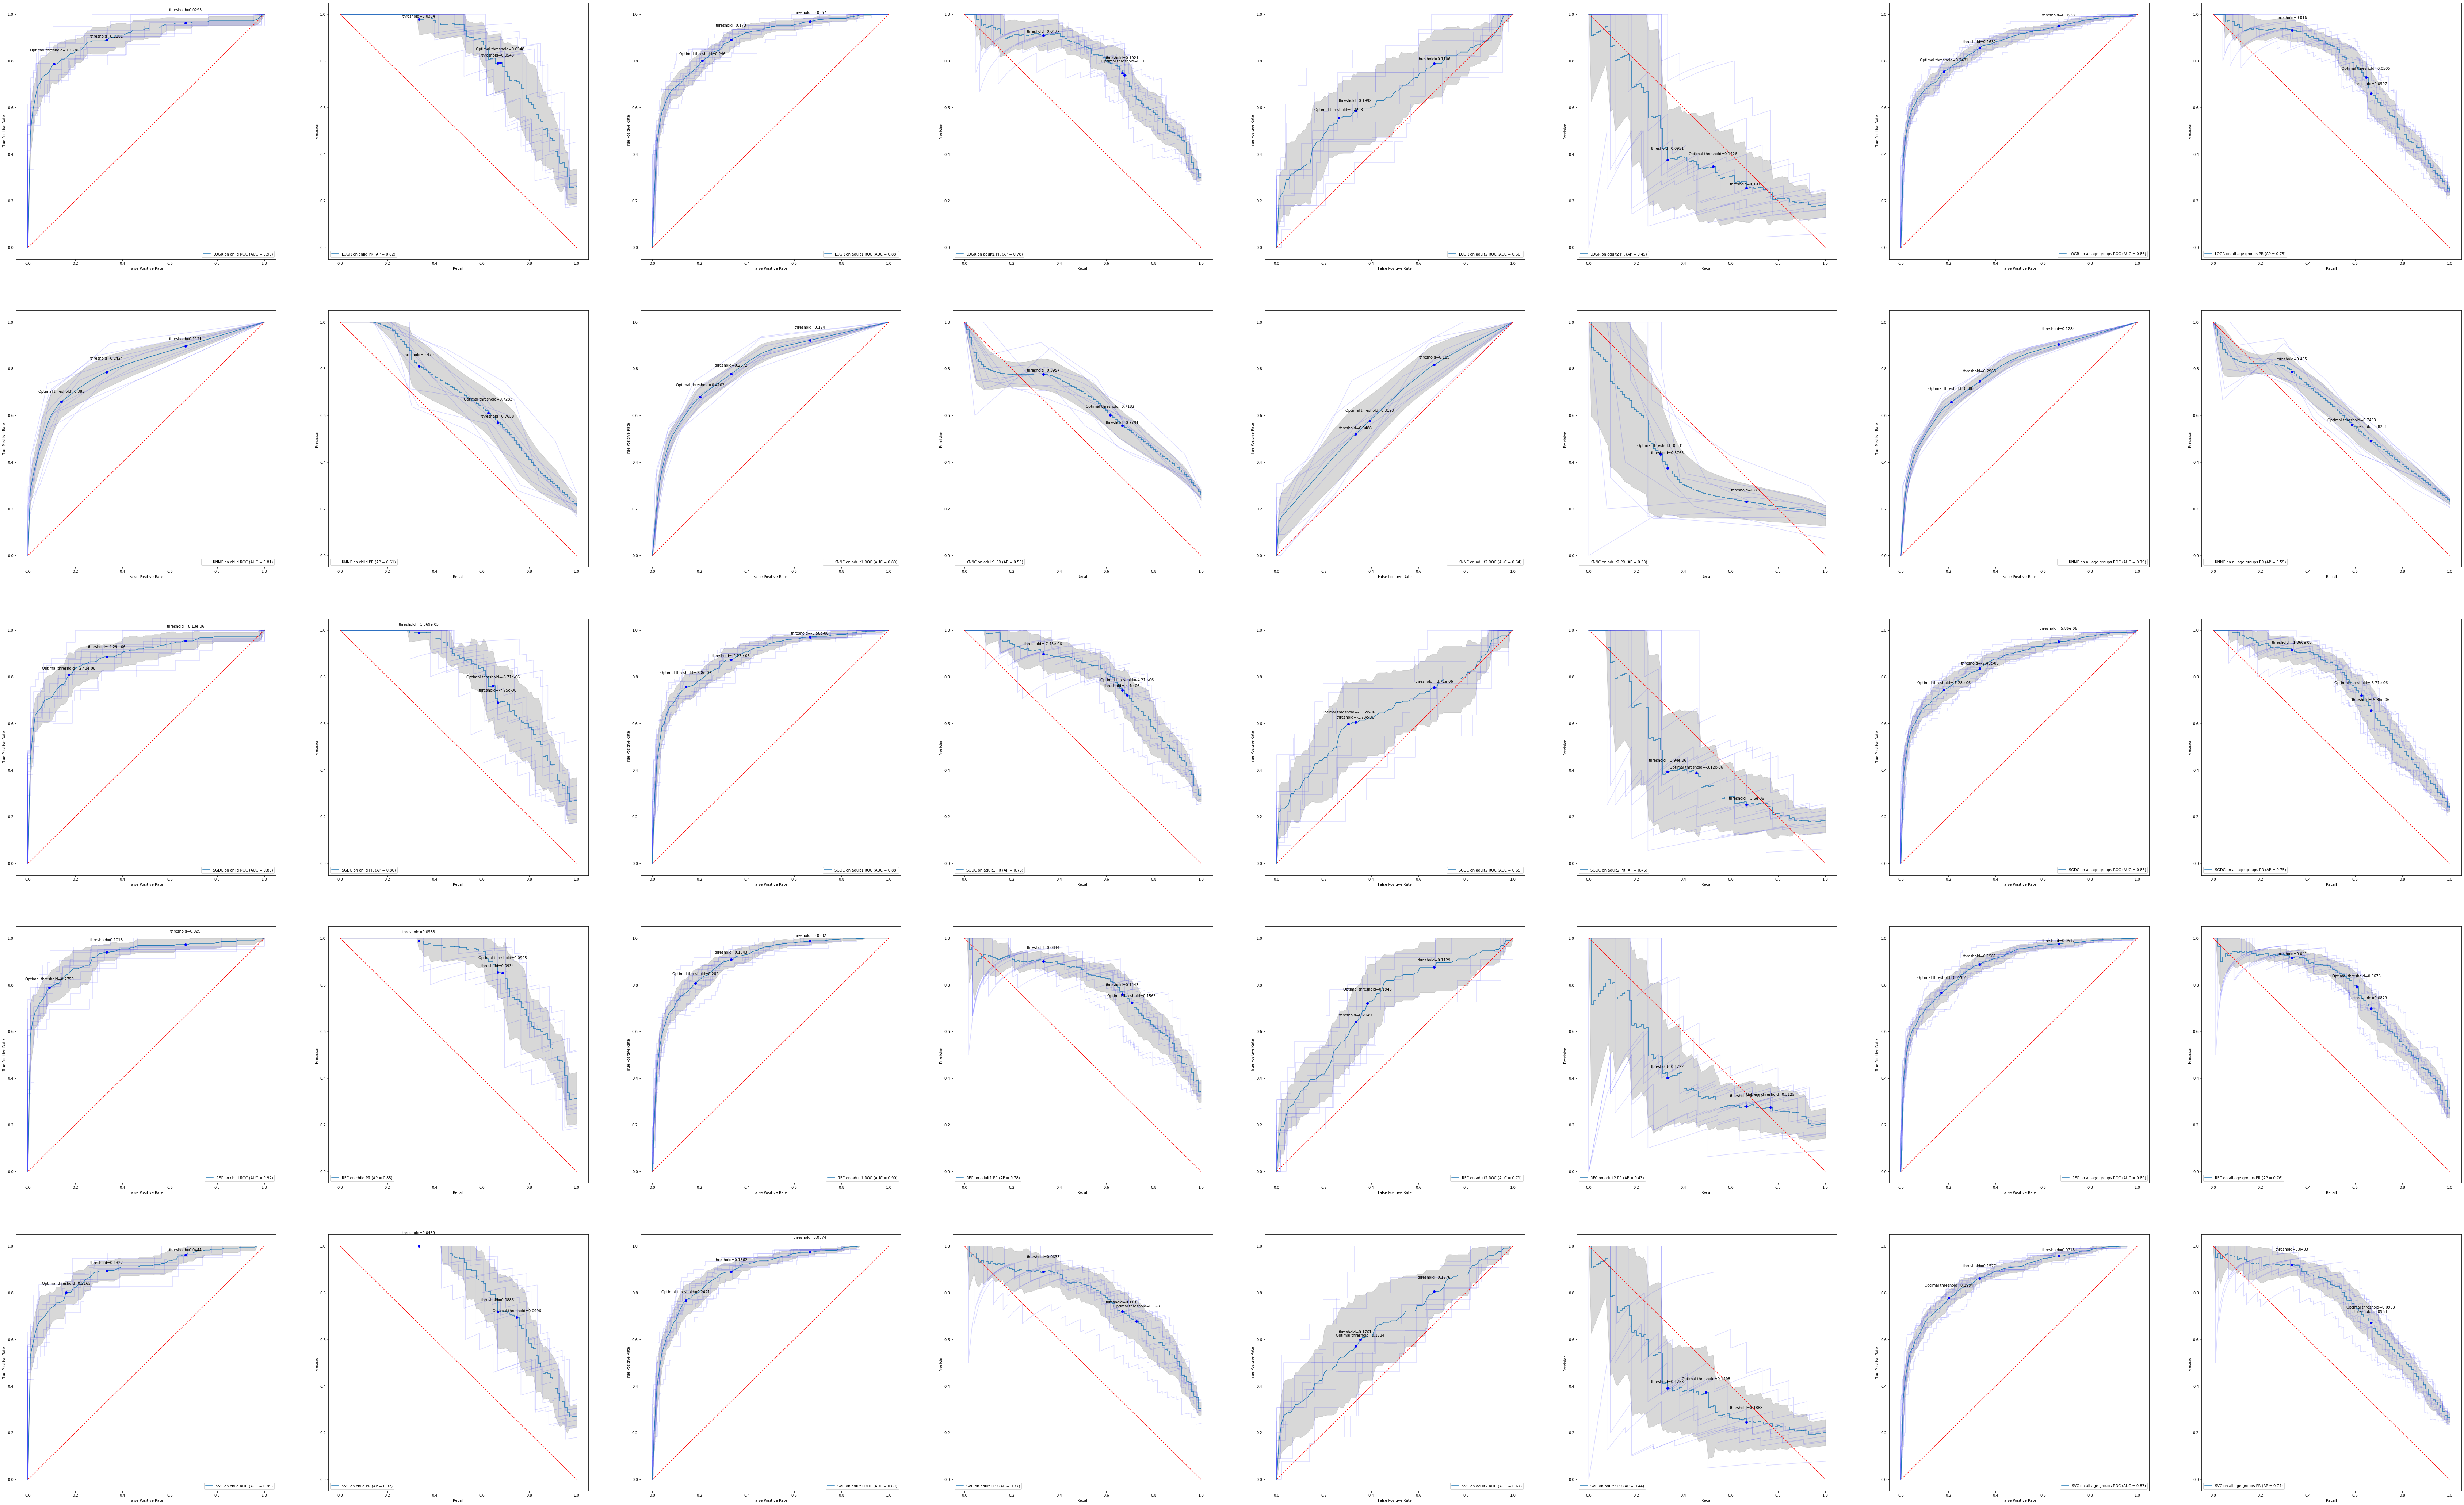

In [128]:
import pandas as pd

df = pd.read_csv("fluvacc metadata - UGA1-5 - 1368 entries with clear vacc status - for figures.txt", sep="\t")  ##TODO: put the name of the file here
evaluation_wrapper(df)

